In [29]:
import numpy as np
from glob import glob
from opendr.renderer import ColoredRenderer
from opendr.lighting import LambertianPointLight
from opendr.camera import ProjectPoints
import sys, os
sys.path.append("/home/windward/gcy/Golf/SMPL/smpl/")
from smpl_webuser.serialization import load_model
import json
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
img_path = '../demo/image/train_1/'
img_files = sorted(glob(os.path.join(img_path, '*.jpg')))
label_path = '../demo/label/train_1'
label_files = sorted(glob(os.path.join(label_path, '*.json')))
smpl_param_path = '../demo/smpl_param/train_1'
pre_files = sorted(glob(os.path.join(smpl_param_path, '*.txt')))
out_pre_path = '../demo/out/train_1_pre'
out_label_path = '../demo/out/train_1_label'

In [41]:
def render(rn, m):
    # Assign attributes to renderer
    w, h = (320, 240)
    rn.camera = ProjectPoints(v=m, rt=np.zeros(3), t=np.array([0, 0, 2.]), f=np.array([w, w])/2., 
                              c=np.array([w, h])/2., k=np.zeros(5))
    rn.frustum = {'near': 1., 'far': 10., 'width': w, 'height': h}
    rn.set(v=m, f=m.f, bgcolor=np.zeros(3))
    # Construct point light source
    rn.vc = LambertianPointLight(
        f=m.f,
        v=rn.v,
        num_verts=len(m),
        light_pos=np.array([-1000, -1000, -2000]),
        vc=np.ones_like(m)*.9,
        light_color=np.array([1., 1., 1.]))
    return rn

In [44]:
def reflect_pose(pose):
    """
    Input is a 72-Dim vector.
    Global rotation (first 3) is left alone.
    """
    right = [11, 8, 5, 2, 14, 17, 19, 21, 23]
    left = [10, 7, 4, 1, 13, 16, 18, 20, 22]
    new_map = {}
    for r_id, l_id in zip(right, left):
        for axis in range(0, 3):
            rind = r_id * 3 + axis
            lind = l_id * 3 + axis
            new_map[rind] = lind
            new_map[lind] = rind
    asis = [id for id in np.arange(0, 24) if id not in right + left]
    for a_id in asis:
        for axis in range(0, 3):
            aind = a_id * 3 + axis
            new_map[aind] = aind
    swap_inds = np.array([new_map[k] for k in sorted(new_map.keys())])
    sign_flip = np.tile([1, -1, -1], (24))
    new_pose = np.take(pose, swap_inds) * sign_flip
    return new_pose

In [50]:
m = load_model('/home/windward/gcy/Golf/SMPL/smpl/models/basicModel_f_lbs_10_207_0_v1.0.0.pkl')
for i in range(len(label_files)):
    if img_files[i][-3:] != 'jpg':
        continue
    with open(label_files[i]) as f:
        label = json.load(f)
    gt_pose = label['pose']
    pre_pose = np.loadtxt(pre_files[i])
    # Create OpenDR renderer
    rn = ColoredRenderer()

    pre_pose = reflect_pose(pre_pose)
    m.pose[3:] = pre_pose[3:]
    m.pose[0] = np.pi
    rn = render(rn, m)
    misc.imsave(os.path.join(out_pre_path, os.path.basename(img_files[i])), rn.r)

    gt_pose = reflect_pose(gt_pose)
    m.pose[3:] = gt_pose[3:]
    m.pose[0] = np.pi
    rn = render(rn, m)
    misc.imsave(os.path.join(out_label_path, os.path.basename(img_files[i])), rn.r)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [58]:
import cv2 as cv
import os

# path = '../demo/image/train_1/'
path = '../demo/out/train_3_pre'
fps = 20  # 视频帧率
fourcc = cv.VideoWriter_fourcc('M', 'J', 'P', 'G')
all_img = sorted(os.listdir(path))
videoWriter = cv.VideoWriter(os.path.join(path, '../train_3_pre.avi'), fourcc, fps, (320, 240))
for i in all_img:
    img = cv.imread(os.path.join(path, i))
    videoWriter.write(img)
videoWriter.release()

# 单张图片的展示

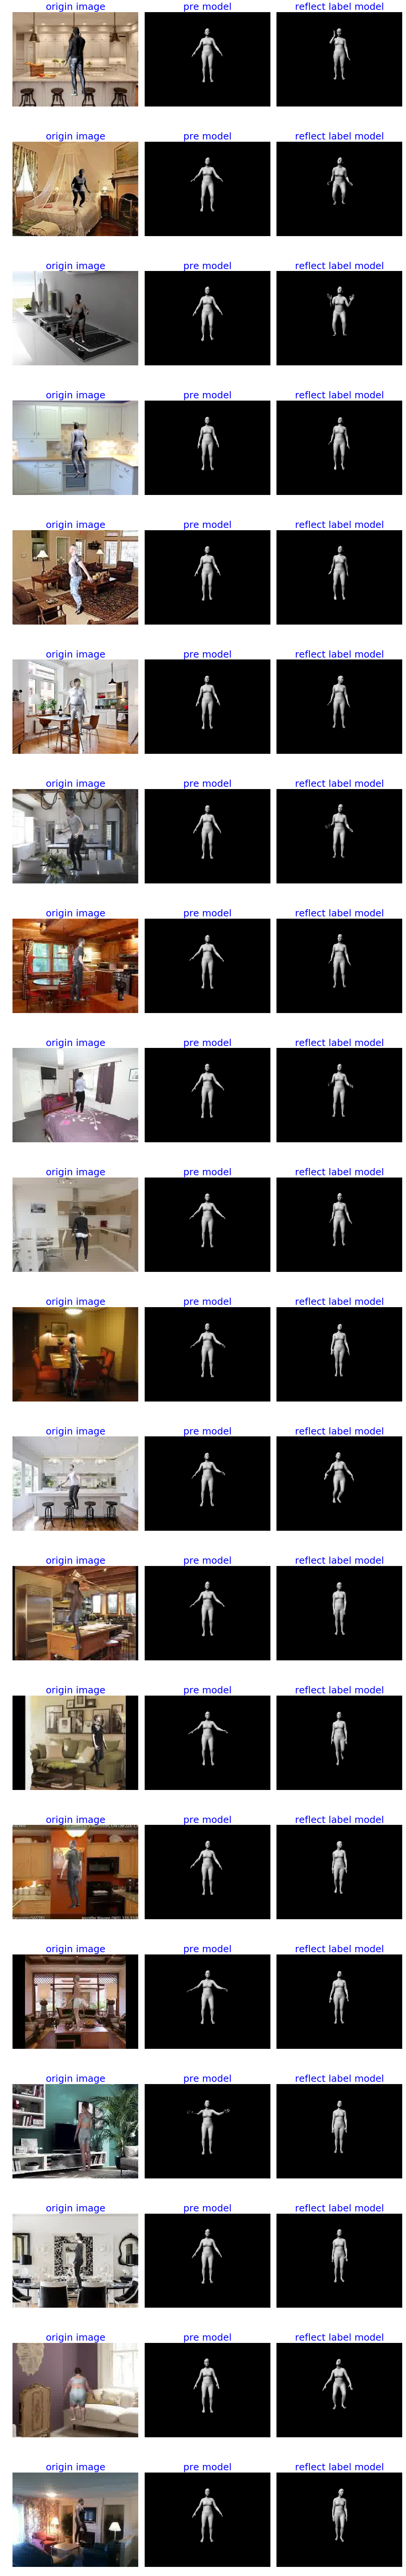

In [147]:
m = load_model('/home/windward/gcy/Golf/SMPL/smpl/models/basicModel_f_lbs_10_207_0_v1.0.0.pkl')
fig = plt.figure(figsize=(15, 5*20))
for i in range(len(label_files)):
    if img_files[i][-3:] != 'jpg':
        continue
    with open(label_files[i]) as f:
        label = json.load(f)
    gt_pose = label['pose']
    pre_pose = np.loadtxt(pre_files[i])
    # Create OpenDR renderer
    rn = ColoredRenderer()
    plt.subplot(20, 3, i*3+1)
    image = plt.imread(img_files[i])
    plt.title('origin image', fontsize=25, color='b')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(20, 3, i*3+2)
    pre_pose = reflect_pose(pre_pose)
    m.pose[3:] = pre_pose[3:]
    m.pose[0] = np.pi
    rn = render(rn, m)
    plt.imshow(rn.r)
    plt.title('pre model', fontsize=25, color='b')
    plt.axis('off')

    plt.subplot(20, 3, i*3+3)
    gt_pose = reflect_pose(gt_pose)
    m.pose[3:] = gt_pose[3:]
    m.pose[0] = np.pi
    rn = render(rn, m)
    plt.imshow(rn.r)
    plt.title('reflect label model', fontsize=25, color='b')
    plt.axis('off')

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=-0.5)    # 调整子图间距
plt.show()

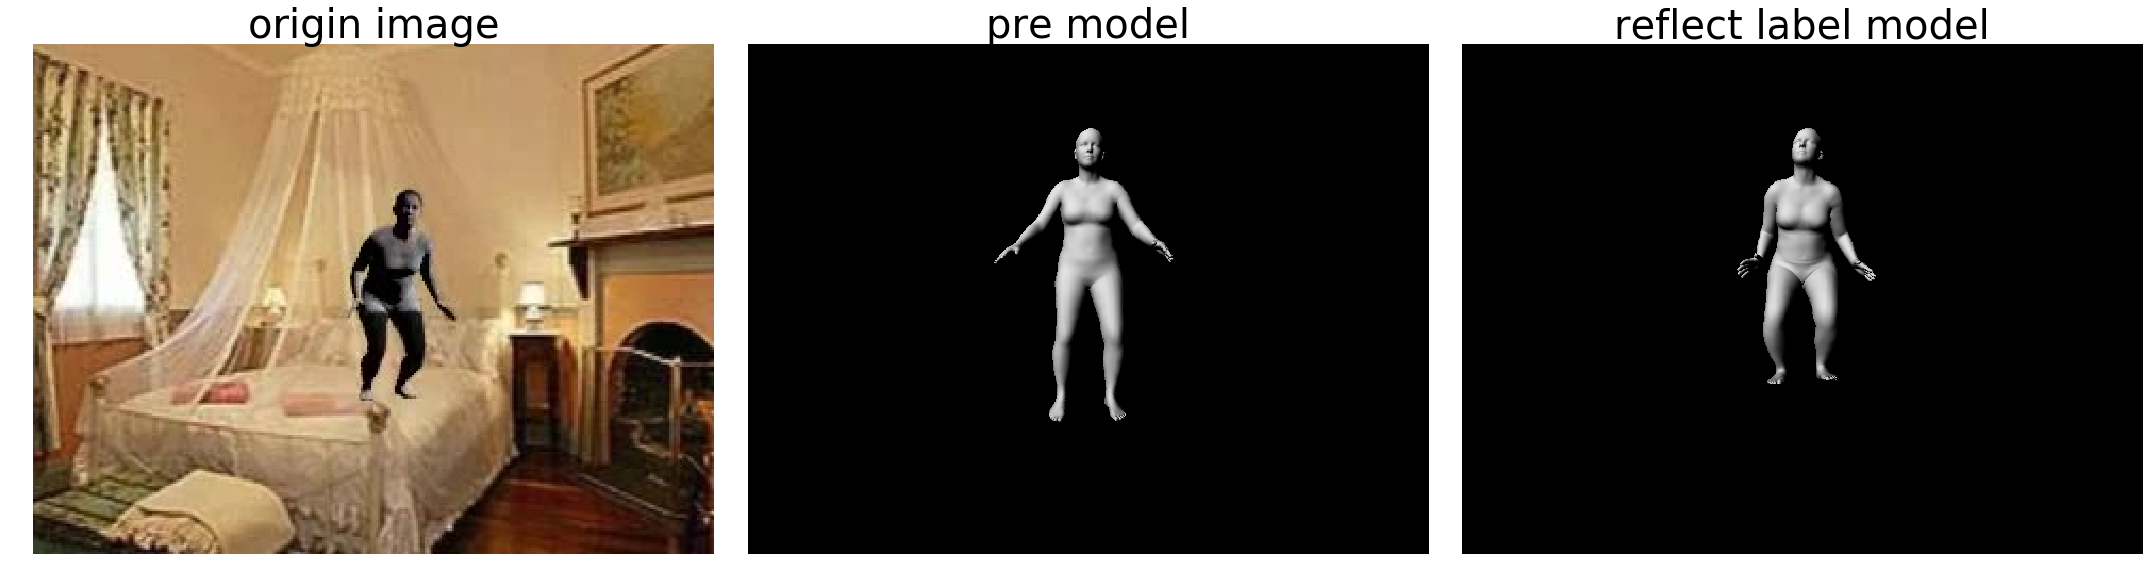

In [153]:
i = 1
fig = plt.figure(figsize=(30, 10))
with open(label_files[i]) as f:
    label = json.load(f)
gt_pose = label['pose']
pre_pose = np.loadtxt(pre_files[i])
# Create OpenDR renderer
rn = ColoredRenderer()
plt.subplot(1, 3, 1)
image = plt.imread(img_files[i])
plt.imshow(image)
plt.title('origin image', fontsize=40)
plt.axis('off')

plt.subplot(1, 3, 2)
pre_pose = reflect_pose(pre_pose)
m.pose[3:] = pre_pose[3:]
m.pose[0] = np.pi
rn = render(rn, m)
plt.imshow(rn.r)
plt.title('pre model', fontsize=40)
plt.axis('off')

plt.subplot(1, 3, 3)
gt_pose = reflect_pose(gt_pose)
m.pose[3:] = gt_pose[3:]
m.pose[0] = np.pi
rn = render(rn, m)
plt.imshow(rn.r)
plt.title('reflect label model', fontsize=40)
plt.axis('off')

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=-0.35)    # 调整子图间距
plt.show()